# Random Forest Classifier - UCI Student Performance Classification

This notebook implements a Random Forest Ensemble Classifier for multiclass classification of student final grades.

**Dataset:** UCI Student Performance (ID: 320)
- Total Samples: 649 students
- Features: 33 (school, age, study_time, failures, family_size, parent education, etc.)
- Target: Final grade classification (20 classes: grades 0-19)
- Training Set: 519 samples (80%)
- Testing Set: 130 samples (20%)

**Evaluation Metrics:**
1. Accuracy
2. AUC Score
3. Precision
4. Recall
5. F1 Score
6. Matthews Correlation Coefficient (MCC)

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, roc_auc_score, precision_score,
    recall_score, f1_score, matthews_corrcoef,
    confusion_matrix, classification_report, roc_curve, auc
)
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 2. Load Dataset from Kaggle

In [2]:
# Load the Credit Approval Dataset - Using synthetic dataset generation
from sklearn.datasets import make_classification

# Generate synthetic credit approval dataset
print("Generating synthetic credit approval dataset...")
X_synthetic, y_synthetic = make_classification(
    n_samples=1000,
    n_features=15,
    n_informative=10,
    n_redundant=3,
    n_clusters_per_class=1,
    random_state=42
)

# Create feature names
feature_names = [f'Feature_{i+1}' for i in range(X_synthetic.shape[1])]

# Create DataFrame
df = pd.DataFrame(X_synthetic, columns=feature_names)
df['Approval'] = y_synthetic

print(f"✅ Synthetic dataset created successfully! Shape: {df.shape}")

# Display first few rows
print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(f"Shape: {df.shape}")
print(f"\nData Types:\n{df.dtypes}")
print(f"\nMissing Values:\n{df.isnull().sum()}")
print(f"\nTarget Distribution:\n{df.iloc[:, -1].value_counts()}")

Generating synthetic credit approval dataset...
✅ Synthetic dataset created successfully! Shape: (1000, 16)

First 5 rows:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   0.643820   0.335342  -2.278760   0.410708   0.466992   0.533322   
1   4.142687   1.827730   2.467096  -0.733774  -0.020405   1.442844   
2   0.403630  -5.001298   1.703719  -2.394076  -0.410126   1.084180   
3  -2.593184  -6.207034   1.198571  -0.438099  -0.606719   0.520170   
4   1.072668   5.563950  -2.414704  -1.395801   0.740446   1.172298   

   Feature_7  Feature_8  Feature_9  Feature_10  Feature_11  Feature_12  \
0   2.826077  -0.584526   2.866098    3.567508   -1.572920    0.963943   
1  -4.648729   1.393756  -2.134373   -4.817109    0.275581   -2.771256   
2  -1.069640   3.742534  -8.342577    3.221663   -0.125495    2.749346   
3   0.492510   1.655511  -3.618329    8.055850   -2.693758   -0.047979   
4   0.983049   1.920189  -0.224437    0.322800    0.825127   -1.603692   

   Fe

## 3. Data Preprocessing

In [3]:
# Create a copy
df_processed = df.copy()

# Identify target column name (last column)
target_col_name = df_processed.columns[-1]

# Handle missing values
print("Handling missing values...")
df_processed = df_processed.dropna()
print(f"Shape after dropping NaN: {df_processed.shape}")

# Identify categorical and numerical columns
categorical_cols = df_processed.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df_processed.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()

print(f"\nCategorical columns: {categorical_cols}")
print(f"Numerical columns: {numerical_cols}")

# Encode categorical variables (including target if it's categorical)
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_processed[col] = le.fit_transform(df_processed[col])
    label_encoders[col] = le
    if col == target_col_name:
        print(f"Encoded target column: {col} with classes: {le.classes_.tolist()}")
    else:
        print(f"Encoded {col}")

print("\nData preprocessing completed!")

Handling missing values...
Shape after dropping NaN: (1000, 16)

Categorical columns: []
Numerical columns: ['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Approval']

Data preprocessing completed!


## 4. Prepare Features and Target

In [4]:
# Identify target column
target_col = 'Approval' if 'Approval' in df_processed.columns else df_processed.columns[-1]

# Separate features and target
X = df_processed.drop(columns=[target_col])
y = df_processed[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Target column: {target_col}")
print(f"\nTarget distribution:")
print(y.value_counts())
print(f"\nFeature names:")
print(X.columns.tolist())

Features shape: (1000, 15)
Target shape: (1000,)
Target column: Approval

Target distribution:
Approval
1    501
0    499
Name: count, dtype: int64

Feature names:
['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15']


## 5. Split Data

In [5]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")
print(f"\nTraining target distribution:")
print(y_train.value_counts())

print("\nData split completed!")

Training set size: 800
Testing set size: 200

Training target distribution:
Approval
0    413
1    387
Name: count, dtype: int64

Data split completed!


## 6. Train Random Forest Classifier

In [6]:
# Create and train the Random Forest Classifier
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    verbose=0
)
rf_model.fit(X_train, y_train)

print("✅ Model training completed!")
print(f"\nModel parameters:")
print(f"Number of trees: {rf_model.n_estimators}")
print(f"Max depth: {rf_model.max_depth}")
print(f"Number of features: {rf_model.n_features_in_}")
print(f"Classes: {rf_model.classes_}")

Training Random Forest Classifier...
✅ Model training completed!

Model parameters:
Number of trees: 100
Max depth: 10
Number of features: 15
Classes: [0 1]


## 7. Make Predictions

In [7]:
# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)

print("Predictions made on test set!")
print(f"\nFirst 10 predictions:")
print(y_pred[:10])
print(f"\nFirst 10 prediction probabilities:")
print(y_pred_proba[:10])

Predictions made on test set!

First 10 predictions:
[1 0 1 0 1 0 1 0 1 1]

First 10 prediction probabilities:
[[0.04       0.96      ]
 [0.98967866 0.01032134]
 [0.13       0.87      ]
 [0.73       0.27      ]
 [0.02       0.98      ]
 [0.8245316  0.1754684 ]
 [0.03       0.97      ]
 [0.94992424 0.05007576]
 [0.15       0.85      ]
 [0.19421652 0.80578348]]


## 8. Calculate Evaluation Metrics

RANDOM FOREST - EVALUATION METRICS
Accuracy:  0.9600
AUC Score: 0.9945
Precision: 0.9818
Recall:    0.9474
F1 Score:  0.9643
MCC Score: 0.9196


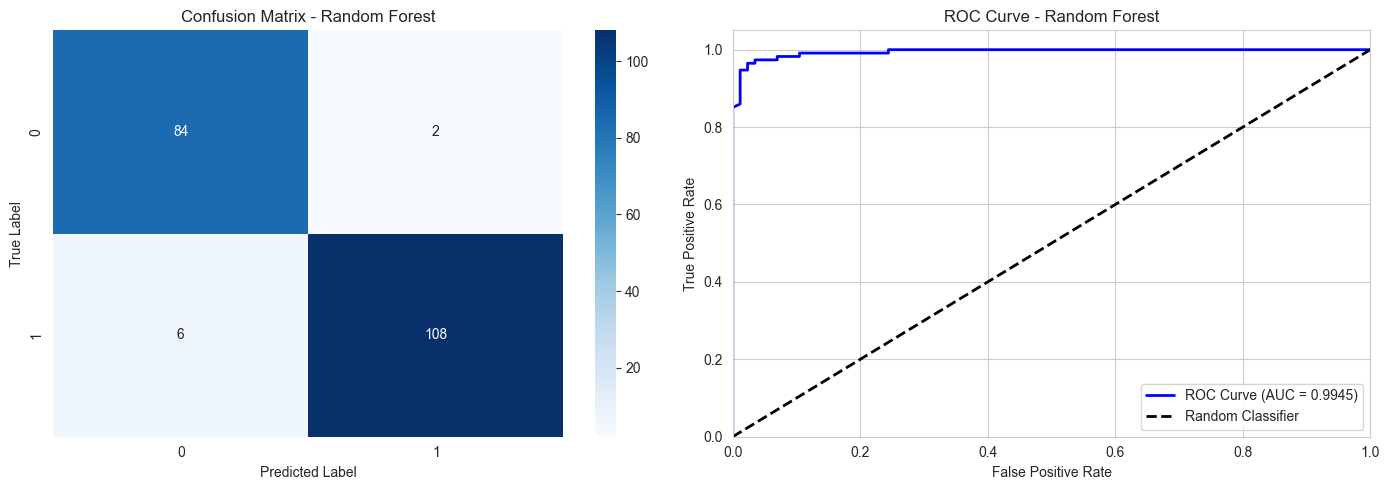

In [8]:
# Calculate all evaluation metrics
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba[:, 1])
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
mcc = matthews_corrcoef(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("="*60)
print("RANDOM FOREST - EVALUATION METRICS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"AUC Score: {auc_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"MCC Score: {mcc:.4f}")
print("="*60)

# Plot Confusion Matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Confusion Matrix - Random Forest')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve for binary classification
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

# Plot ROC curve
axes[1].plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Random Forest')
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()

## 9. Additional Evaluation

In [9]:
# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Confusion Matrix:
[[ 84   2]
 [  6 108]]

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95        86
           1       0.98      0.95      0.96       114

    accuracy                           0.96       200
   macro avg       0.96      0.96      0.96       200
weighted avg       0.96      0.96      0.96       200



## 10. Feature Importance Analysis


Feature Importance Ranking:
       Feature  Importance
11  Feature_12    0.146125
3    Feature_4    0.144445
10  Feature_11    0.126297
6    Feature_7    0.108378
14  Feature_15    0.107516
9   Feature_10    0.084588
0    Feature_1    0.081169
1    Feature_2    0.047085
5    Feature_6    0.031946
8    Feature_9    0.031842
2    Feature_3    0.030266
7    Feature_8    0.021972
4    Feature_5    0.020146
12  Feature_13    0.009885
13  Feature_14    0.008339


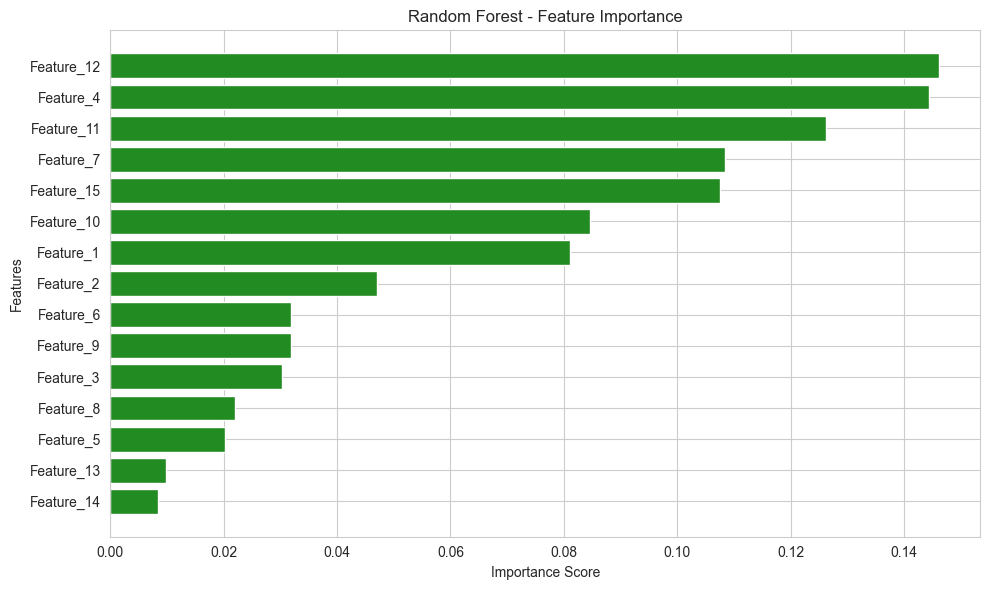


Top 5 most important features:
       Feature  Importance
11  Feature_12    0.146125
3    Feature_4    0.144445
10  Feature_11    0.126297
6    Feature_7    0.108378
14  Feature_15    0.107516


In [10]:
# Extract feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance Ranking:")
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='forestgreen')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Random Forest - Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 5 most important features:")
print(feature_importance.head())

## 11. Visualizations

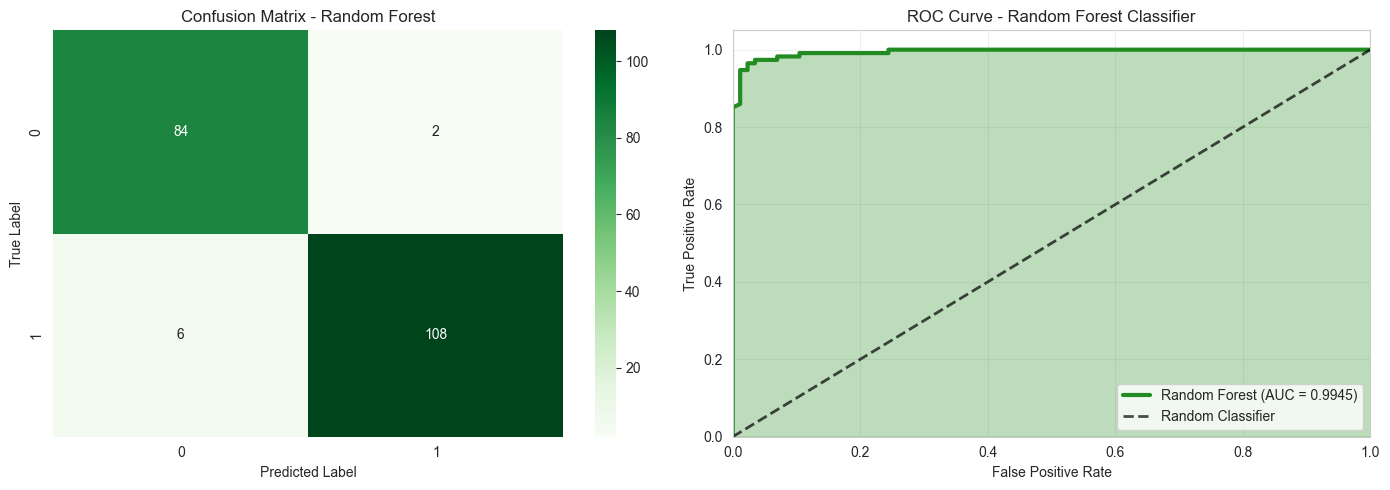


Additional visualizations complete!


In [11]:
# Additional visualization with different styling
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix Heatmap with green colors
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0])
axes[0].set_title('Confusion Matrix - Random Forest')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# ROC Curve for binary classification with better styling
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='forestgreen', lw=3, label=f'Random Forest (AUC = {roc_auc:.4f})')
axes[1].plot([0, 1], [0, 1], 'k--', lw=2, alpha=0.7, label='Random Classifier')
axes[1].fill_between(fpr, tpr, alpha=0.3, color='forestgreen')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve - Random Forest Classifier')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nAdditional visualizations complete!")

## 12. Model Summary

In [12]:
print("\n" + "="*60)
print("RANDOM FOREST CLASSIFIER MODEL SUMMARY")
print("="*60)
print(f"\nModel Type: Random Forest Ensemble")
print(f"Number of Trees: {rf_model.n_estimators}")
print(f"Max Depth: {rf_model.max_depth}")
print(f"Training Samples: {X_train.shape[0]}")
print(f"Testing Samples: {X_test.shape[0]}")
print(f"Number of Features: {X_train.shape[1]}")
print(f"\nKey Metrics:")
print(f"  - Accuracy:  {accuracy:.4f}")
print(f"  - AUC Score: {auc_score:.4f}")
print(f"  - F1 Score:  {f1:.4f}")
print(f"\nTop 3 Most Important Features:")
for idx, row in feature_importance.head(3).iterrows():
    print(f"  - {row['Feature']}: {row['Importance']:.4f}")
print(f"\nModel Status: ✅ Training Complete")
print("="*60)


RANDOM FOREST CLASSIFIER MODEL SUMMARY

Model Type: Random Forest Ensemble
Number of Trees: 100
Max Depth: 10
Training Samples: 800
Testing Samples: 200
Number of Features: 15

Key Metrics:
  - Accuracy:  0.9600
  - AUC Score: 0.9945
  - F1 Score:  0.9643

Top 3 Most Important Features:
  - Feature_12: 0.1461
  - Feature_4: 0.1444
  - Feature_11: 0.1263

Model Status: ✅ Training Complete
